In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import flika as flk
from matplotlib.cm import gray, inferno, magma, viridis
from skimage.exposure import rescale_intensity as rescale
from skimage.transform import downscale_local_mean as downscale
from fish.image.alignment import estimate_translation
from moviepy.editor import ImageSequenceClip, VideoClip, concatenate_videoclips
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy.ndimage import median_filter
from fish.image.zds import ZDS

from dask.distributed import Client
from fish.util.distributed import get_cluster
from dask.array import coarsen
import dask.array as da
from pathlib import Path
import os
flk.start_flika()

Starting flika


Starting flika inside IPython


In [2]:
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 400
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

def reg(fixed, moving):
    from fish.image.alignment import estimate_translation    
    from numpy import expand_dims
    affs =  estimate_translation(fixed.squeeze(), moving.squeeze()).affine
    return expand_dims(affs, 0)

20171107_1_3_gfaprgeco_gfaptrpv1_6dpf_csn_20171107_113628 :: deep (z 0 : 5) , t 4771, t 4846, 5063
20171022_1_3_GFAPrgeco_injectedTRPV1_6dpf_beforeaftercsn10uM_20171022_141052 :: giving-up triggered events are global, hard to define initiation zone
20171022_4_3_GFAPrgeco_injectedTRPV1_6dpf_bathesystemwater_bathecsn5uM :: great moment around 6230

In [3]:
base_dirs = ('/groups/ahrens/ahrenslab/YuMu/SPIM/active_datasets/20171107/fish1/20171107_1_3_gfaprgeco_gfaptrpv1_6dpf_csn_20171107_113628/',
           '/nrs/ahrens/Yu/SPIM/active_dataset/20171022/fish1/20171022_1_3_GFAPrgeco_injectedTRPV1_6dpf_beforeaftercsn10uM_20171022_141052/',
            '/groups/ahrens/ahrenslab/YuMu/SPIM/active_datasets/20171107/fish2/20171107_2_3_gfaprgeco_gfaptrpv1_6dpf_csn_20171107_135106/',
            '/groups/ahrens/ahrenslab/YuMu/SPIM/active_datasets/20171022/fish4/20171022_4_3_GFAPrgeco_injectedTRPV1_6dpf_bathesystemwater_bathecsn5uM_20171022_230815/')

In [4]:
from scipy.ndimage.filters import median_filter
from functools import partial

base_dir = base_dirs[1] 
dset = ZDS(base_dir + 'raw/')
data = dset.data
reg_path = base_dir + 'regparams_affine.npy'

medfilt = partial(median_filter, size=(1,1,5,5))
data_filt = data.map_blocks(medfilt)    
anat_ref = data_filt[data_filt.shape[0]//2 + np.arange(-5,5)].mean(0).compute(scheduler='threads')

try: 
    shifts = -np.load(reg_path)[:,:-1,-1]
except FileNotFoundError:
    shifts = None    
    print('No valid regparams found. They will be estimated')
data.shape

(10464, 27, 772, 800)

In [5]:
cluster = get_cluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.36.110.24:44940 Dashboard: http://10.36.110.24:45405/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [15]:
#roi = (slice(6500, None), slice(0,None), slice(None), slice(None))
roi = (slice(3400, 4300), slice(0,None), slice(None), slice(None))
data_tx = data[roi].map_blocks(shift_yx, shifts[roi[0]], dtype='float32')
data_filt = data_tx.map_blocks(lambda v: median_filter(v, size=(1,1,3,3)))
ds_xy = 4
data_ds = coarsen(np.mean, data_filt, {2: ds_xy, 3: ds_xy})
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], data_ds.shape[1], 32,32))
data_dff = rechunked.map_blocks(mydff, dtype='float32')

In [16]:
%%time
import time
cluster.start_workers(400)
time.sleep(10)
result = data_dff.compute()
cluster.stop_workers(cluster.workers)

CPU times: user 1min 7s, sys: 1min 6s, total: 2min 13s
Wall time: 2min 32s


In [17]:
out_path = '/groups/ahrens/ahrenslab/projects/ngm/'
start, stop = np.arange(data.shape[0])[roi[0]][0], np.arange(data.shape[0])[roi[0]][-1]
out_fname = dset.metadata['data_header'] + f'_t{start}_t{stop}.tif'

In [18]:
print(out_path + out_fname)
from skimage.io import imsave
imsave(out_path + out_fname, result, imagej=True)

/groups/ahrens/ahrenslab/projects/ngm/20171022_1_3_GFAPrgeco_injectedTRPV1_6dpf_beforeaftercsn10uM_t3400_t4299.tif


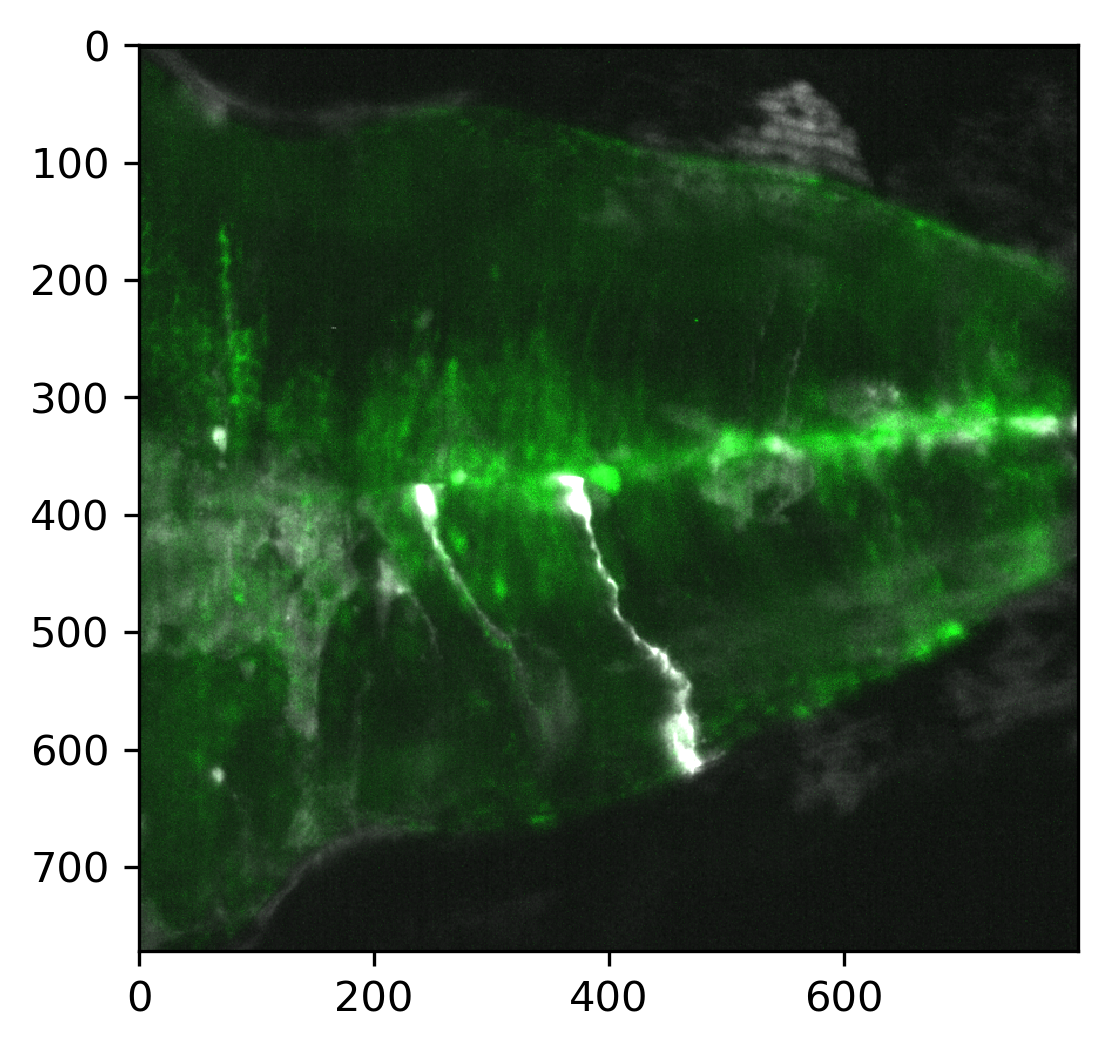

In [19]:
try:
    dset_g = ZDS(str(next(Path(base_dir).parent.glob('*GREEN*'))) + os.path.sep)
    dset_r = ZDS(str(next(Path(base_dir).parent.glob('*RED*'))) + os.path.sep)
    anat_g = dset_g.data.mean(0).compute(scheduler='threads')
    anat_r = dset_r.data.mean(0).compute(scheduler='threads')    
    
except StopIteration:
    anat_g = imread(str(next(Path(base_dir).parent.glob('*TRPV1*'))))
    anat_r = imread(str(next(Path(base_dir).parent.glob('*RGECO*'))))
    dset_r = []
    dset_g = []

    
expn = dset.metadata['data_header']
sample = dset.data[-1].compute(scheduler='threads')

fig, axs = plt.subplots(dpi=300)

tx = estimate_translation(sample.max(0), anat_r.max(0))
r_tx= gray(rescale(tx.transform(anat_r.max(0)),in_range=(100,200), out_range=(0,1))) * np.array([1,1,1,.5])
g_tx = gray(rescale(tx.transform(anat_g.max(0)), in_range=(100,200), out_range=(0,1))) * np.array([1,1,1,1])
tmp = gray(rescale(sample.max(0).astype('float32'),in_range=(100,450), out_range=(0,1))) * np.array([0,1,0,1])
axs.imshow((g_tx + tmp).clip(0,1))

In [20]:
result = imread(out_path + out_fname)

In [21]:
crop = slice(None), slice(1, 20, 4), slice(None), slice(10,-10)
chunk = result[crop]
chunk = chunk.reshape(chunk.shape[0], chunk.shape[1] * chunk.shape[2], chunk.shape[3])
anat_g_tx = np.array([tx.transform(a) for a in anat_g])

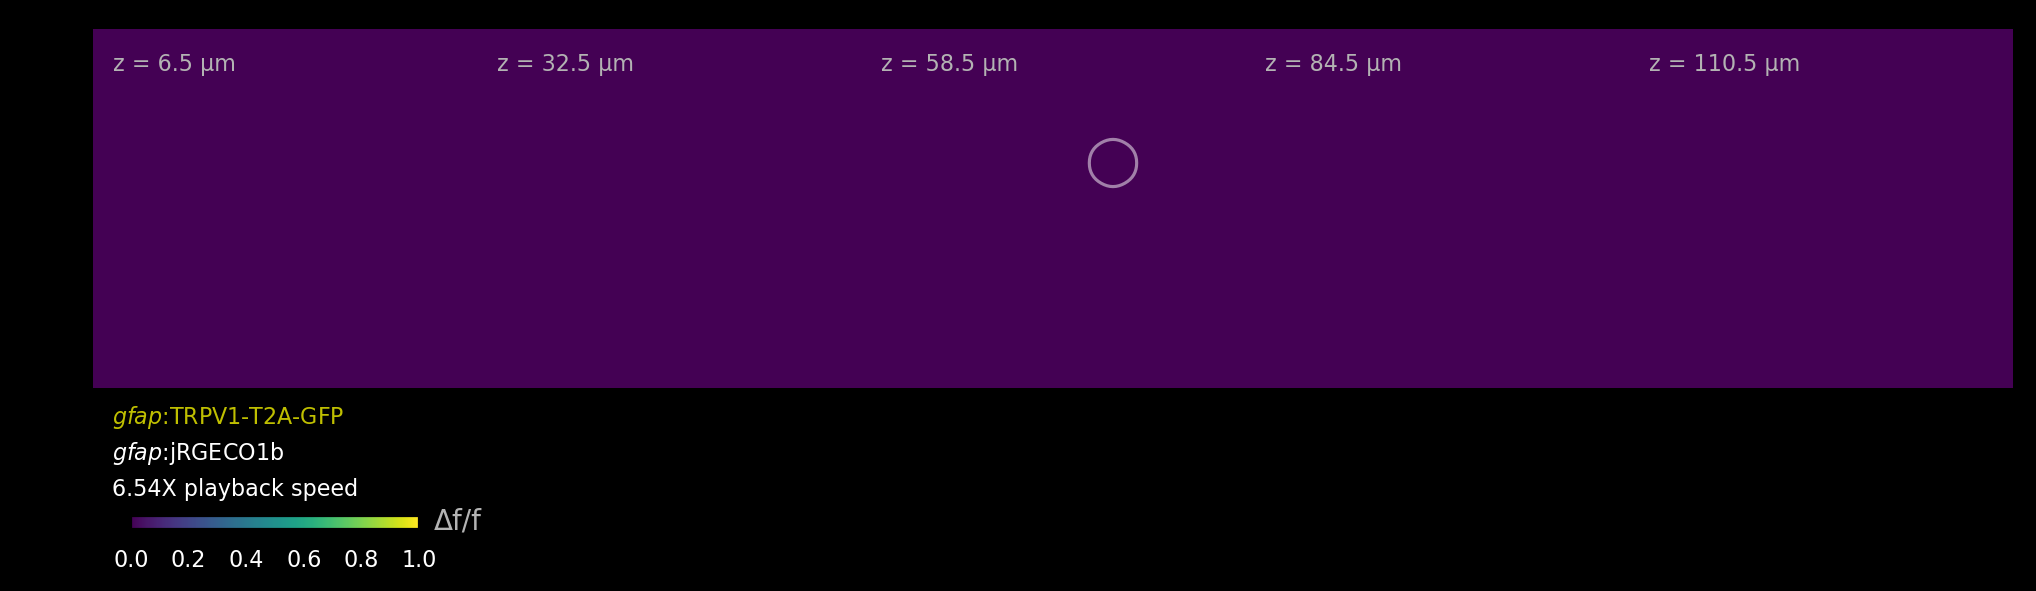

In [22]:
in_range_dff = (0,1)
fps = 10
figsize = (9.6, 6.4)
fig_dff, axs = plt.subplots(dpi=200, figsize=figsize)
fig_dff.set_facecolor('k')
axs.set_facecolor('k')
axs.set_position([0,0,1,1])
axs.axis('off')
axs.imshow(np.zeros(chunk[0].shape[::-1]), clim=in_range_dff)
axs_cbar = fig_dff.add_axes([.02, .25, .15, .01])
cbar = plt.colorbar(axs.images[0], cax=axs_cbar, orientation='horizontal')
axs_cbar.text(1.05, 0, '\u0394f/f', transform=axs_cbar.transAxes, fontdict={'fontsize' : 10, 'color' : (.7, .7, .7)})
axs_cbar.tick_params(labelcolor='w', labelsize=8)
axs_cbar.set_xticks([0,1])

anat_rgeco = downscale(anat_ref[crop[1]], (1,4,4))[:,crop[2], crop[3]].reshape(*chunk.shape[1:])
anat_trp = anat_g_tx[crop[1],::4,::4][:,crop[2], crop[3]].reshape(*chunk.shape[1:])
anat_trp_rgb = gray(rescale(anat_trp, in_range=(108,120), out_range=(0,1))) * np.array([.5,.5,0,.1])
anat_rgeco_rgb = gray(rescale(anat_rgeco, in_range=(100,200), out_range=(0,1))) * np.array([.5,.5,.5,.5])

sample = result[0][crop[1:]]
zlabel_x = 10 + np.linspace(0, anat_trp.shape[0] - sample.shape[1], sample.shape[0]).astype('int')
zlabel_y = [20]
zlabels = [f'z = {z} µm' for z in np.arange(dset.shape[1])[roi[1]][crop[1]] * dset.metadata['z_step']]

fd_small = {'fontsize' : 8, 'color' : (.7, .7, .7)}
[axs.text(x, y, zlabels[ind], fontdict=fd_small) for y in zlabel_y for ind, x in enumerate(zlabel_x)]

trp_label = dict(x = .01, y=-.1, s='$\it{gfap}$:TRPV1-T2A-GFP', transform=axs.transAxes, fontdict=dict(color='y', size=8))
rgeco_label = dict(x = .01, y=-.2, s='$\it{gfap}$:jRGECO1b', transform=axs.transAxes, fontdict=dict(color='w', size=8))
timing_label = dict(x = .01, y =-.3, s=f'{fps/dset.metadata["volume_rate"]:.2f}X playback speed',transform=axs.transAxes, fontdict=dict(color='w', size=8))
source_cell_label = dict(x = 498, y=73, s='\u25EF', fontdict=dict(color='w', size=18, alpha=.5))

axs.text(**trp_label)
axs.text(**rgeco_label)
axs.text(**source_cell_label)
axs.text(**timing_label)
ind = 0
def draw_frame(t_):
    global ind
    chunk_rgb = magma(rescale(chunk[ind],in_range=in_range_dff, out_range=(0,1)))
    composite = chunk_rgb + anat_rgeco_rgb + anat_trp_rgb
    composite = composite.transpose(1,0,2)
    if len(axs.images) == 0:
        axs.imshow(composite)
    else:
        axs.images[0].set_data(composite)
    ind += 1
    return mplfig_to_npimage(fig_dff)

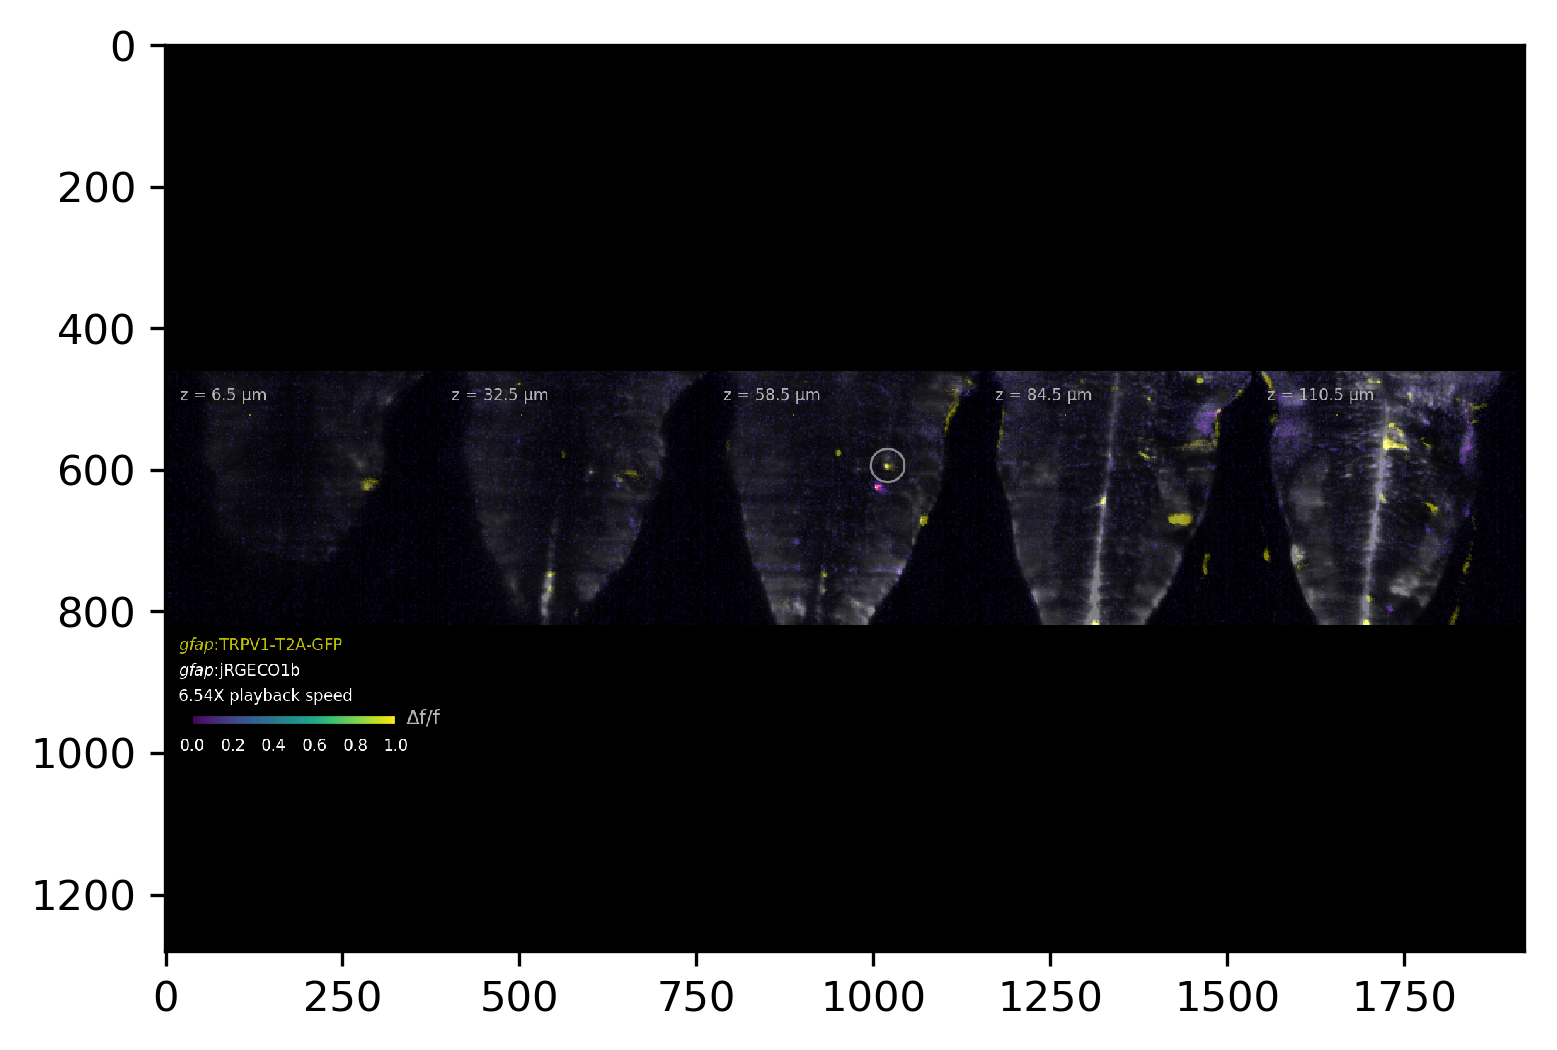

In [23]:
fig, axs_ = plt.subplots(dpi=300)
plt.imshow(draw_frame(0))

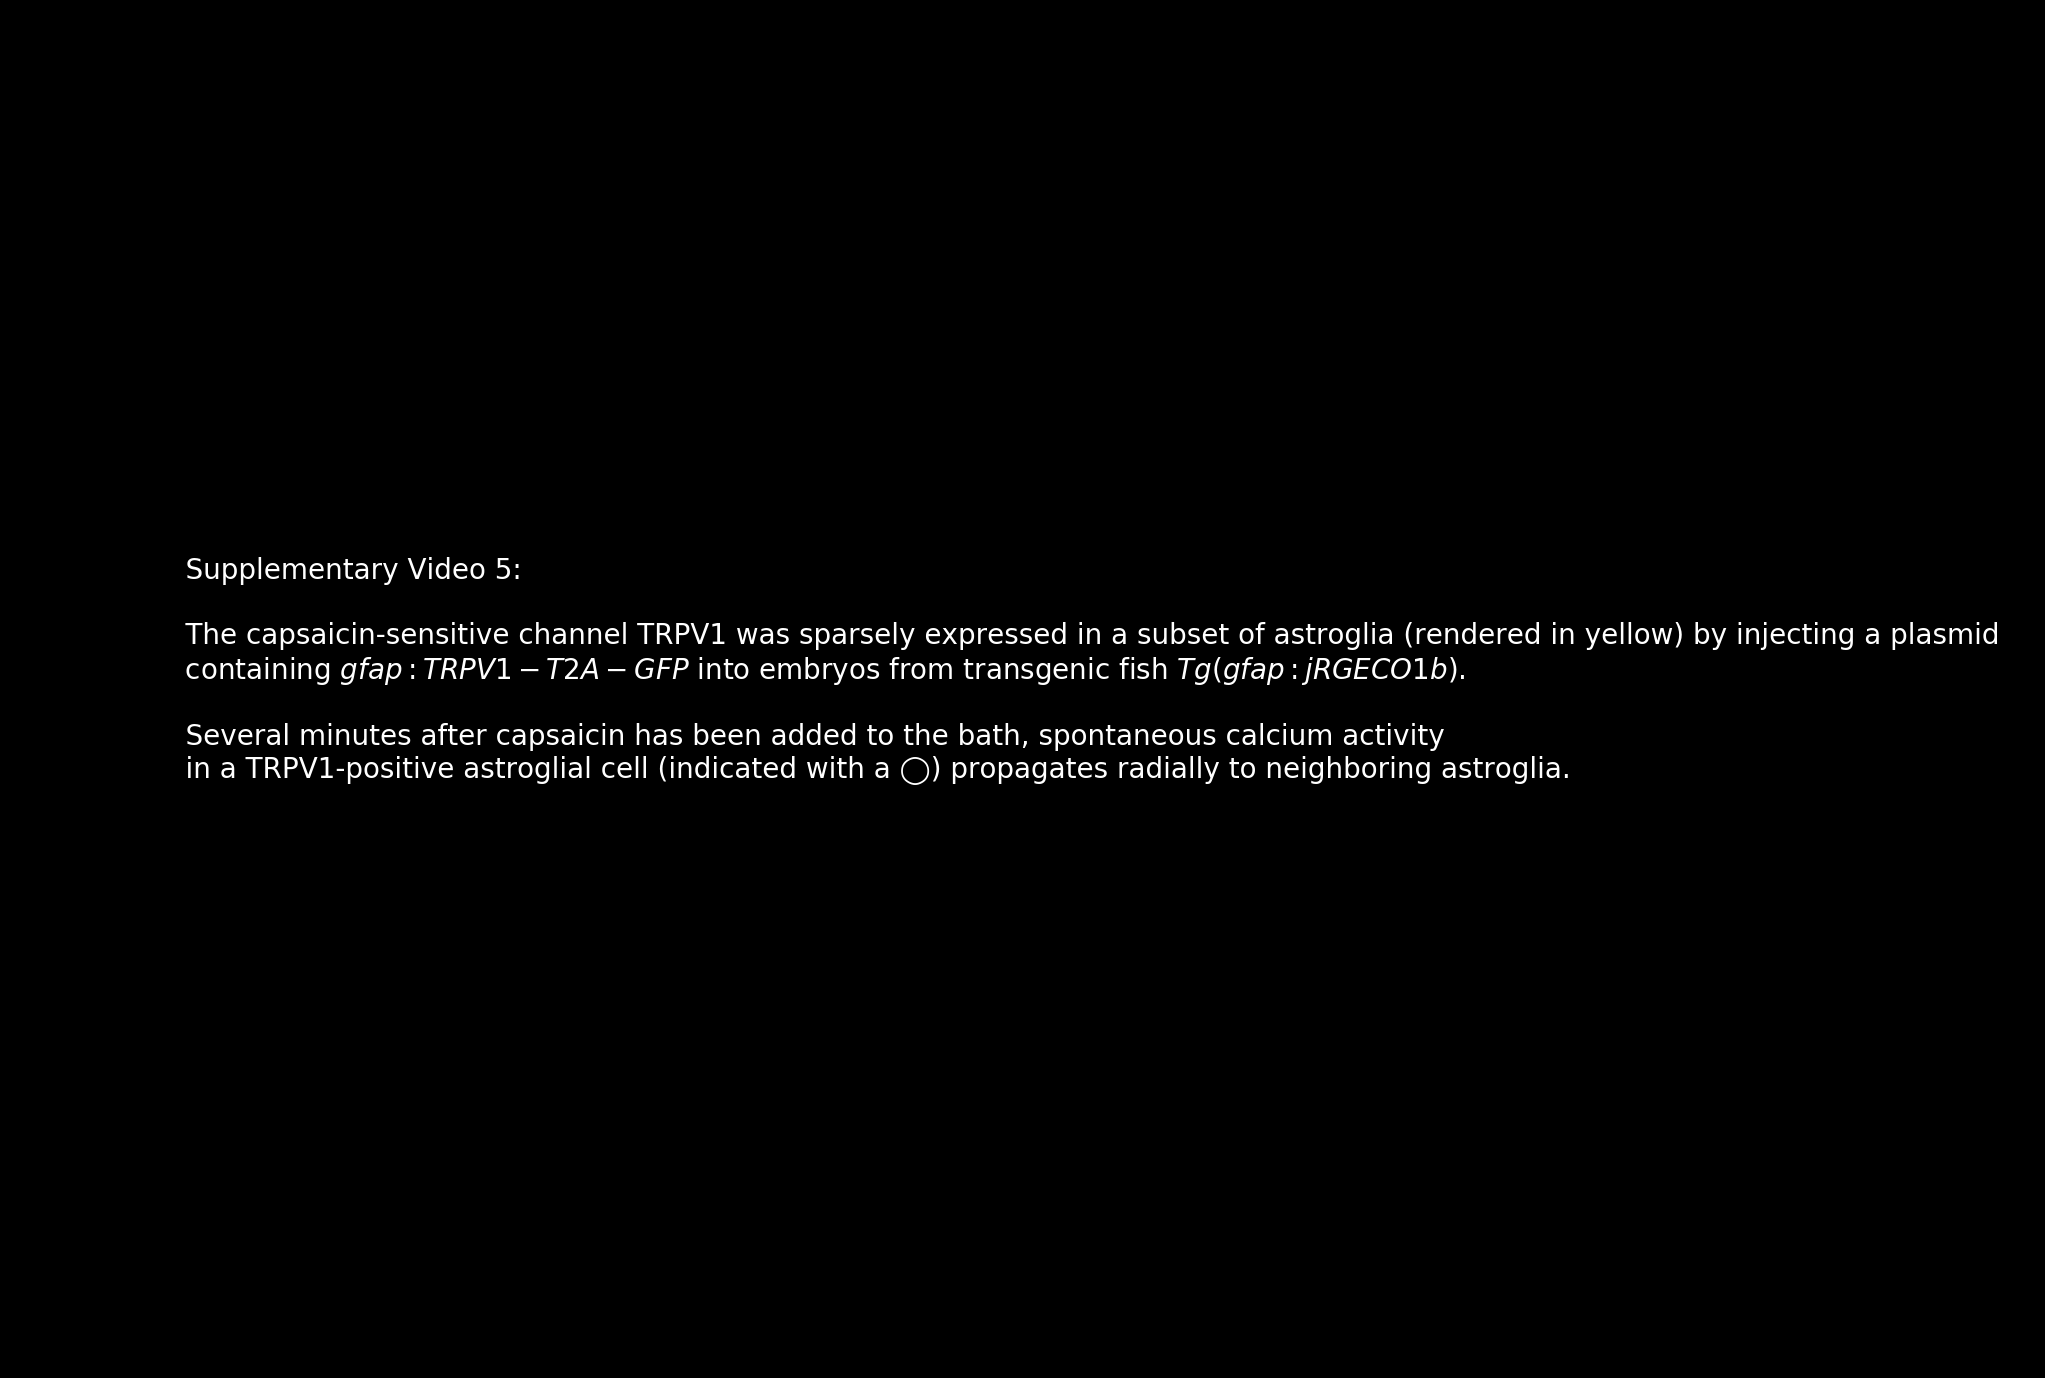

In [24]:
## make the title card 
title_dur = 15
fig_intro = plt.figure(dpi=200, figsize=figsize, facecolor='k')
ax_intro = fig_intro.add_axes((0,0,1,1))
ax_intro.set_facecolor('k')
intro_text ='''
            Supplementary Video 5:
            
            The capsaicin-sensitive channel TRPV1 was sparsely expressed in a subset of astroglia (rendered in yellow) by injecting a plasmid 
            containing $\it{gfap:TRPV1-T2A-GFP}$ into embryos from transgenic fish $\it{Tg(gfap:jRGECO1b)}$.
                    
            Several minutes after capsaicin has been added to the bath, spontaneous calcium activity 
            in a TRPV1-positive astroglial cell (indicated with a \u25EF) propagates radially to neighboring astroglia.             
            '''
            
ax_intro.text(.5,
              .5,
              intro_text, 
              fontdict=dict(color='w'), 
              transform=ax_intro.transAxes, 
             ha = 'center',
             va='center',
             multialignment='left')

def drawf_intro(t_):
    return mplfig_to_npimage(fig_intro)

title_clip = VideoClip(drawf_intro, duration=title_dur)

In [26]:
#data_dur = 200 / fps
data_dur = result.shape[0] / fps
data_clip = VideoClip(draw_frame, duration=data_dur)

codec = 'h264'
exp_name = dset.metadata['data_header']
vid_fname = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}_t{roi[0].start}t{roi[0].stop}.mp4'
ind = 0 

composite_clip = concatenate_videoclips([title_clip, data_clip])
composite_clip.write_videofile(vid_fname, audio=False, codec=codec, fps=fps, ffmpeg_params=['-pix_fmt', 'yuv420p'])

[MoviePy] >>>> Building video /groups/ahrens/ahrenslab/davis/tmp/20171022_1_3_GFAPrgeco_injectedTRPV1_6dpf_beforeaftercsn10uM_t3400t4300.mp4
[MoviePy] Writing video /groups/ahrens/ahrenslab/davis/tmp/20171022_1_3_GFAPrgeco_injectedTRPV1_6dpf_beforeaftercsn10uM_t3400t4300.mp4


100%|█████████▉| 1050/1051 [02:03<00:00,  8.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /groups/ahrens/ahrenslab/davis/tmp/20171022_1_3_GFAPrgeco_injectedTRPV1_6dpf_beforeaftercsn10uM_t3400t4300.mp4 

